# 線形多項分類器によるMNISTデータの分類

線形多項分類器とSoftmax関数を用いて、MNISTの手書き数字画像の分類を行います。

理論的な背景については、下記のBlog記事を参照してください。

・[TensorFlow Tutorialの数学的背景 − MNIST For ML Beginners（その2）](http://enakai00.hatenablog.com/entry/2016/02/14/175505)

### モジュールのインポート

はじめに、必要なモジュールをインポートしておきます。

In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

### データセットの用意

TensorFlowには、MNISTのデータセットをダウンロードする関数が用意されていますので、これを利用します。

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


これにより、以下のデータが利用可能になりました。

* mnist.train.data：トレーニングセット（画像データ）
* mnist.train.label：トレーニングセット（正解ラベル）
* mnist.test.data：テストセット（画像データ）
* mnist.test.label：テストセット（正解ラベル）

次のように、next_batchメソッドで、指定数のトレーニングデータを取り出すことができます。

In [3]:
data, label = mnist.train.next_batch(15)

正解ラベルは、${\mathbf t}=(0,\cdots,1,\cdots,0)$ のように、正解を r として、r+1 番目の数字が 1 になっているベクトル形式で与えられます。

先ほど取り出した15個のデータを確認すると、次のようになっています。

In [4]:
label

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]])

これは、argmax関数で正解の数字に変換することができます。

In [5]:
np.array([np.argmax(t) for t in label])

array([7, 3, 4, 6, 1, 8, 1, 0, 9, 8, 0, 3, 1, 2, 7])

一方、画像データの方は、28x28サイズの各ピクセルの濃度を数値化したものを一列にならべたベクトル ${\mathbf x} = (x_0,\cdots,x_m)$ （$m=783$）として与えられます。

先ほどの正解ラベルとあわせて、画像化して表示すると、次のようになります。

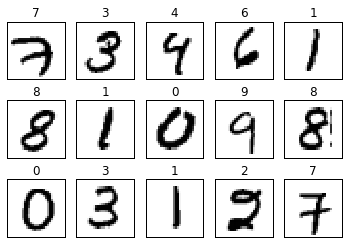

In [6]:
fig = plt.figure()
for i in range(15):
    subplot = fig.add_subplot(3,5,i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('%d' % np.argmax(label[i]))
    subplot.imshow(data[i].reshape(28,28), vmax=1, vmin=0,
                   cmap=plt.cm.gray_r, interpolation='nearest')

最初の「7」などは、いかにも判別が難しそうなことがわかります・・・。

### 分類モデルの定義

これらの画像を判別する「線形多項分類器」を定義していきます。

それぞれの画像データは 28x28=784個の数値の並びとして表現されており、これは、784次元空間の1点とみなすことができます。そこで、この784次元空間を10個の領域に分割することで、それぞれの画像がどの数字に対応するかを判別します。

まず、画像データ ${\mathbf x}=(x_0,\cdots,x_m)$ を入力とする10個の線形関数 $(f_0,\cdots,f_9)$ を次式で定義します。

　$(f_0,\cdots,f_9) = (x_0,\cdots,x_m)
\begin{pmatrix}
w_{00} & w_{01} & \cdots & w_{09} \\
w_{10} & w_{11} & \cdots & w_{19} \\
\vdots \\
w_{m0} & w_{m1} & \cdots & w_{m9}\\
\end{pmatrix}
+ (b_0,\cdots,b_9)$

ここで、次の行列 $W$ と $b$ が、トレーニングで最適化するべきパラメーターとなります。

　${\mathbf W}=
\begin{pmatrix}
w_{00} & w_{01} & \cdots & w_{09} \\
w_{10} & w_{11} & \cdots & w_{19} \\
\vdots \\
w_{m0} & w_{m1} & \cdots & w_{m9}\\
\end{pmatrix}
,\,\,\,\,
{\mathbf b}=(b_0,\cdots,b_9)$

これらをTensorFlowのコードで表現すると、次になります。トレーニングデータを入力する入れ物はplaceholderクラス、最適化するべきパラメーターはVariableクラスのインスタンスとして用意します。matmulは、行列の積を計算します。

In [7]:
x = tf.placeholder(tf.float32, [None, 784])
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([1,10]))
f = tf.matmul(x, W) + b

$(f_0,\cdots,f_9)$ は、それぞれ、対応する数字である可能性を示しており、値が大きいほど、その数字の確率が高いものと考えます。ただし、この値自身は、$-\infty$ 〜 $\infty$ の任意の値をとるので、この値そのものを確率と考えることはできません。これを確率の値に変換するのが、次のSoftmax関数です。

　$P_k({\mathbf x}) = {e^{f_k({\mathbf x})} / \sum_{k'=0}^9 e^{f_{k'}({\mathbf x})} }\,\,(k=0,\cdots,9)$

次のように、確率としての条件を満たしていることがわかります。

　$0<P_0,\cdots,P_9<1,\,\,P_0 + P_1 + \cdots +P_0 = 1$
 
この確率を並べたベクトルを ${\mathbf y} = (P_0,\cdots,P_9)$ とします。

TensorFlowでは、次のように、softmax関数で計算できます。

In [8]:
y = tf.nn.softmax(f)

### 最尤推定法によるモデルの最適化

続いて、正解ラベルを用いてパラメーターを最適化するための指標を定義します。ここでは、最尤推定法の考え方に従います。

まず、先ほど計算した確率でトレーニングデータを予測したと考えます。この時、$n$ 番目のデータ ${\mathbf x}_n$（正解は $r$）に対して正解を与える確率は $P_r$ になります。これは、正解ラベル ${\mathbf t}_n = (0,\cdots,1,\cdots,0)$ を用いると、次のように書けます。

　$P_r = {e^{f_r({\mathbf x}_n)} / \sum_{k'=0}^9 e^{f_{k'}({\mathbf x}_n)}}$
$ =\prod_{k=0}^9 \left\{ e^{f_k({\mathbf x}_n)} / \sum_{k'=0}^9 e^{f_{k'} ({\mathbf x}_n)}\right\}  ^{t_{nk}}$

ここで、$t_{nk}$ は正解ラベル ${\mathbf t}_n$ の $k$ 番目の成分を表します。

したがって、すべてのトレーニングセットに正解する確率は、次式になります。

　$P = \prod_{n=1}^N\prod_{k=0}^9 \left\{e^{f_k({\mathbf x_n})} / \sum_{k'=0}^9 e^{f_{k'}({\mathbf x_n})}\right\}^{t_{nk}} = \prod_{n=1}^N\prod_{k=0}^9 y_{nk}^{t_{nk}}$
 
ここで、

　$y_{nk} = e^{f_k({\mathbf x_n})} / \sum_{k'=0}^9 e^{f_{k'}({\mathbf x_n})}$
 
は、$n$ 番目のデータに対する確率ベクトル ${\mathbf y}_n = (P_0({\mathbf x}_n),\cdots,P_9({\mathbf x}_n))$ の $k$ 番目の成分になっています。

最尤推定法では、この「すべてのトレーニングセットに正解する確率 $P$」を最大化するように、パラメーターを調整していきます。TensorFlowに最適化の計算を行わせる場合は、内部的な計算を簡単にするために、「$P$ の対数の符号違い」（ロス関数）を与えて、これを最小にするパラメーターを探していきます。

今の場合、ロス関数は次のようになります。

　${\rm Loss} = -\log P = -\sum_{n=1}^N\sum_{k=0}^9 t_{nk}\log y_{nk}$
 
これは、統計学の用語で、「クロスエントロピー」と呼ばれる値に一致しています。

クロスエントロピーをTensorFlowのコードで記述すると、次のようになります。y_ は、正解ラベル ${\mathbf t}$ を保存するplaceholderで、reduce_sumは、複数のベクトル（行列）について、すべての成分を足し合わせる関数です。

In [9]:
y_ = tf.placeholder(tf.float32, [None, 10])
cross_entropy = -tf.reduce_sum(y_ * tf.log(y))

この値を最小化するように、勾配降下法GradientDescentOptimizerでパラメーターを調整していきます。

In [10]:
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

### トレーニングの実施

それでは、TensorFlowを用いて、実際にパラメーターの最適化を実施します。

はじめに、トレーニングセッションのインスタンスを生成して、パラメーター（Variable）を初期化します。

In [11]:
sess = tf.InteractiveSession()
tf.initialize_all_variables().run()

トレーニングセットから100個づつデータを取り出して、バッチトレーニングを1000回実施します。Xeon 16コアの環境で、約5秒間でトレーニングが完了します。

In [12]:
%%time
for i in range(1000):
  batch_xs, batch_ys = mnist.train.next_batch(100)
  train_step.run({x: batch_xs, y_: batch_ys})

CPU times: user 6.03 s, sys: 4.58 s, total: 10.6 s
Wall time: 4.33 s


トレーニング結果を用いて、テストセットに対する予測の正解率がどの程度になるかを確認します。

予測確率 ${\mathbf y}=(P_0,\cdots,P_9)$ において、確率が最大になるものを判別結果として採用します。この場合、${\mathbf y}$ と正解ラベル ${\mathbf t}$ について、それぞれの最大値を与える成分が一致すれば正解です。

次は、テストセットの全データについて、正解／不正解を 1, 0 の数値で表したリストを作成します。evelメソッドは、引数で指定された値をplaceholderに入力して、計算結果を返します。

In [13]:
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
iscorrect = tf.cast(correct_prediction, tf.float32)
result = iscorrect.eval({x: mnist.test.images, y_: mnist.test.labels})
result

array([ 1.,  1.,  1., ...,  1.,  1.,  1.], dtype=float32)

これから正解率を計算すると、次のようになります。約90%の正解率が達成できました。

In [14]:
np.mean(result)

0.91390002

### トレーニング結果の確認

残念がら不正解だったデータは、どのようなものか確認してみましょう。

準備として、予測 prediction と正解 actual をリストに格納しておきます。

In [15]:
prediction = tf.argmax(y, 1).eval({x: mnist.test.images, y_: mnist.test.labels})
actual = [np.argmax(label) for label in mnist.test.labels]

予測と正解が一致しないデータのインデックスを集めて、先頭から15個を画像表示してみます。画像の上のラベルは「予測／正解」を示します。

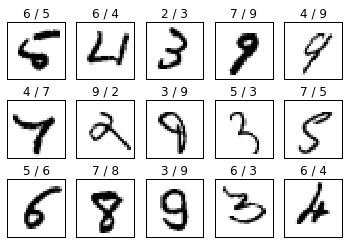

In [16]:
incorrect = [i for i, (x, y) in enumerate(zip(prediction, actual)) if x != y]

fig = plt.figure()
for i, j in enumerate(incorrect[0:15]):
    subplot = fig.add_subplot(3, 5, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('%d / %d' % (prediction[j], actual[j]))
    subplot.imshow(mnist.test.images[j].reshape(28,28), vmax=1, vmin=0,
                   cmap=plt.cm.gray_r, interpolation='nearest')

今回用意したモデルは、図形としての類似性に基づいて判定しているため、極端に歪んだ画像は正しく判定できていないことがわかります。判別精度を向上するには、単なる図形としての類似性ではなく、「数字としての類似性」を表す特徴を抽出する必要があります。